# start here

In [17]:
import wikipedia
import pandas as pd
import numpy as np
import urllib
import json
import os
import requests
import re #regular expressions

import string
import networkx as nx
from networkx.algorithms import bipartite
import io
from operator import itemgetter
import math

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from pathlib import Path
from heapq import nlargest
from heapq import nsmallest
from wordcloud import WordCloud

### Scraper

In [2]:
def scrape(page_title): # scrapping the List page
    baseurl = "http://en.wikipedia.org/w/api.php/?"
    action = "action=query"
    title = 'titles=' + urllib.parse.quote(page_title) 
    content = "prop=revisions"
    rvprop ="rvprop=timestamp|content"
    dataformat = "format=json&&utf8="
    rvdir = "rvdir=older" #sort revisions from newest to oldest
    limit = "rvlimit=1" #consider only the first revision
    query = "%s%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, title, content,
                                          rvprop, dataformat, rvdir,  limit)
    wiki= urllib.request.urlopen(query)
    wiki = json.loads(wiki.read())
    wiki = list(wiki['query']['pages'].values())[0][u'revisions'][0][u'*']   #as the relevant text is stored in the * variable this is the one we want to look into
    return wiki

### Collecting countynames for lookup - and saveing to csv for some light datamanipulation

In [3]:
url = 'https://ck3.paradoxwikis.com/List_of_counties'#this step links you to a website. do check the website before you connect to it via this code
html = requests.get(url,allow_redirects=True).content
df_list = pd.read_html(html)
df_counties = df_list[-1]
df_counties.columns = df_counties.columns.droplevel(1)
df_counties['ID'] = df_counties['ID'].str[2:]#the variabels in the ID list starts with c_ this step removes this and makes them more suitable for use in the wikipedia scraper
df_counties['Duchy'] = df_counties['Duchy'] + "_Duchy"#this step does nothing for the code per se, but prevents duchy, kingdom and empire nodes from being merged with County nodes of the same name, when making networks with this .csv file later
df_counties['Kingdom'] = df_counties['Kingdom'] + "_Kingdom"
df_counties['Empire'] = df_counties['Empire'] + "_Empire"
df_counties['Religion'] = df_counties['Religion'] + "_Religion"
df_counties['Culture'] = df_counties['Culture'] + "_Culture"
df_counties.to_csv('counties.csv', header=True)#this step will place a .csv file on you computer, contatining a tabel from the website above
df_counties.head(5)

,County,County,Duchy,Kingdom,Empire,Baronies,Development,Development,Special Buildings/Slots,Religion,Culture,ID
0,NaN,Middlesex,Essex_Duchy,England_Kingdom,Britannia_Empire,5,9,13,1,Catholicism_Religion,Anglo-Saxon_Culture,middlesex
1,NaN,Essex,Essex_Duchy,England_Kingdom,Britannia_Empire,4,6,6,0,Catholicism_Religion,Anglo-Saxon_Culture,essex
2,NaN,Bedford,Essex_Duchy,England_Kingdom,Britannia_Empire,3,6,6,0,Catholicism_Religion,Anglo-Saxon_Culture,bedford
3,NaN,Hertfordshire,Essex_Duchy,England_Kingdom,Britannia_Empire,3,6,6,0,Catholicism_Religion,Anglo-Saxon_Culture,hertfordshire
4,NaN,Buckinghamshire,Essex_Duchy,England_Kingdom,Britannia_Empire,4,6,6,0,Catholicism_Religion,Anglo-Saxon_Culture,buckinghamshire


### Reload from .Csv and order our dataset

In [4]:
df_counties1 = pd.read_csv('counties.csv', usecols=[2,3,4,5,10,11,12])# here we reload only the usefull parts fo the .csv and save that as our working copy
df_counties1.to_csv('counties1.csv', header=True)
df_counties1.head(5)#notice the name change from county to county.1

,County.1,Duchy,Kingdom,Empire,Religion,Culture,ID
0,Middlesex,Essex_Duchy,England_Kingdom,Britannia_Empire,Catholicism_Religion,Anglo-Saxon_Culture,middlesex
1,Essex,Essex_Duchy,England_Kingdom,Britannia_Empire,Catholicism_Religion,Anglo-Saxon_Culture,essex
2,Bedford,Essex_Duchy,England_Kingdom,Britannia_Empire,Catholicism_Religion,Anglo-Saxon_Culture,bedford
3,Hertfordshire,Essex_Duchy,England_Kingdom,Britannia_Empire,Catholicism_Religion,Anglo-Saxon_Culture,hertfordshire
4,Buckinghamshire,Essex_Duchy,England_Kingdom,Britannia_Empire,Catholicism_Religion,Anglo-Saxon_Culture,buckinghamshire


### Creating a network from Countys

In [5]:
County = set(df_counties1['County.1'])
Duchy = set(df_counties1['Duchy'])
Kingdom = set(df_counties1['Kingdom'])
Empire = set(df_counties1['Empire'])
Culture = set(df_counties1['Culture'])
Religion = set(df_counties1['Religion'])

### Wikipedia lookup/downloader

In [6]:
#this codeblock scrapes 2051 wiki pages. run at your own risk
#df_counties1 = pd.read_csv('counties.csv', usecols=[2,12])
#iteration = 0
#for row in df_counties1.iterrows():
#    try:
#        key = row[1]['County.1']#notice the header name from above
#        link = row[1]['ID']
#        filename= 'counties/' +  key + '.txt'#this step requires there to be a folder called countries
#        value = scrape(str(link))#run with both link and key for slightly more pages. Link alone gives 1981 pages while link AND key gives 2051
#        #print(value)
#        with io.open(filename, 'w', encoding='utf-8') as textfile:
#            textfile.write(u''+ str(value))
#            textfile.close()
#        iteration +=1
#        #if iteration%150 == 149:
#         #   clear_output()
#        print('%s out of %s' %(row[0], len(df_counties)))##this scraper continues till it is done. Printing the number of each done itteration
#          #  input('Press enter to continue...')
#    except:
#        print('failed for', row)
#        pass

# Natrual language processing-NLP

### first we merge all .txt files into one long string in one .txt file

In [ ]:
exceptions = 0
path = r"C:\Users\Rolfo\Desktop\DTU1\Projects\counties"#path to your folder with wiki .txt files
files = os.listdir(path)
with open("Wikiall.txt", "w", encoding='utf-8') as fo: #opens a file and merges your txts into it
    for infile in files:
        try:
            with open(os.path.join(path, infile)) as fin:
                for line in fin:
                    fo.write(line)
        except Exception as e:
            exceptions +=1
            print(e)
#print('number of exceptions: ' + str(exceptions))

### Tokenizer loop for the top 30 higest scoreing countys, found via Gephi

In [8]:
#dont run rewrite the precious wikipages
#exceptions = 0
#topbetweenness = {"Tunis", "Bura", "Sibi", "Mansura", "Aran", "Faereyar", "Orkney", "Shetland", "Kamru", "Dausar", "Arawan", "Tahoua", "Kerch", "Vargashi", "Petropavl", "Fuerteventura", "Madeira", "Canarias", "Itanagar", "Cetatea AlbÄƒ", "Chilia", "Visegrad", "Hewes", "Marmaros", "Csanad", "Temes", "Arad", "Csongrad", "Bacs"} # while SzerÃ©m was part of the list, the letters in that name breaks code so it was removed 
#path = r"C:\Users\Rolfo\Desktop\DTU1\Projects\counties"#path to your folder with wiki .txt files
#files = os.listdir(path)
#for row in topbetweenness:
#    try:
#        key = row
#        filename= 'counties/' +  key + '.txt'#this step requires there to be a folder called countries
#        #print(value)
#        with io.open(filename, 'w', encoding='utf-8') as textfile:
#            textfile.write(u''+ nltk.word_tokenize(str(textfile))
#            textfile.close()    
#    except Exception as e:
#        exceptions +=1
#        print(e)
#print('number of exceptions: ' + str(exceptions))

### Tokenizer for the higest scoreing county, Tunis, found via Gephi

In [9]:
county_Tunis=[]

countyTunis= open(r'C:\Users\Rolfo\Desktop\DTU1\Projects\counties\Tunis.txt', encoding='utf-8').read()
county_Tunis += nltk.word_tokenize(countyTunis)
Tunis_tokens = [word.lower() for word in county_Tunis if word.isalnum()]
TF_Tunis = FreqDist(Tunis_tokens)
print(len(Tunis_tokens))

12695


### Making a wordcloud of all words

In [10]:
print(len(files))

2054


#### Tokeniser for all

In [11]:
county_words=[]

countylist= open(r'C:\Users\Rolfo\Desktop\DTU1\Projects\Wikiall.txt', encoding='utf-8').read()
county_words += nltk.word_tokenize(countylist)
all_tokens = [word.lower() for word in county_words if word.isalnum()]
TF_county = FreqDist(all_tokens)

print(len(all_tokens))

648856


In [12]:
#wordcloud = []
#textcounty = ""
#for token in all_tokens:#convert my list of words to a string
#    textcounty += token
# generate a word cloud image for All-County
#wordcloud.append(WordCloud(max_font_size=40, collocations = False, background_color='white').generate(textcounty))


### Making a wordcloud of words from counties with highest betweenness centrality

the TF-TR (term frequency term ratio are calculated for all words in the games cultures. Using a c value of 10 gives reasonable results. 

In general for some token $t$ with term frequency $\textrm{TF}^{(u)}_t$, in culture $u$ where $u \in \{m,d\}$, weight is defined as:
 
$w_t^{(m)}=\frac{TF_t^{(m)}}{TF_t^{(d)}+c}$,
and
$w_t^{(d)}=\frac{TF_t^{(d)}}{TF_t^{(m)}+c}$

where $c$ is a constant to avoid division by 0.

we are now ready to do lists for each culture, where the ranking of token $t$ on list $u$ is given by $\textrm{TF}^{(u)}_t \times w_{t}^{(u)}$. This is called the TF-TR lists.

In [13]:
c=5#this is a constant to avoid dividing by zero
TF_TR_county = dict([(word, TF_county[word]/(TF_Tunis[word]+c)) for word in TF_county])
TF_TR_Tunis = dict([(word, TF_Tunis[word]/(TF_county[word]+c)) for word in TF_Tunis])

In [18]:
N=5
sorted(TF_TR_Tunis.items(), key = itemgetter(1), reverse = True)[:N]
Tunis_WordCloudText = ' '.join([word for word in list(TF_TR_Tunis.keys()) for i in range(math.ceil(TF_TR_Tunis[word]))])

In [22]:
sorted(TF_TR_county.items(), key = itemgetter(1), reverse = True)[:N]
county_WordCloudText = ' '.join([word for word in list(TF_TR_county.keys()) for i in range(math.ceil(TF_TR_county[word]))])

(-0.5, 399.5, 199.5, -0.5)

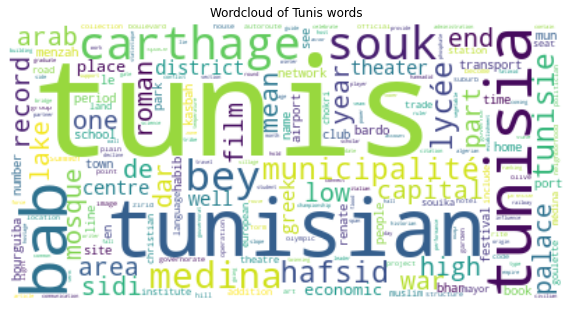

In [20]:
plt.figure(figsize=(10,20))
Tunis_wordcloud = WordCloud(collocations=False,  background_color='white').generate(Tunis_WordCloudText)
plt.imshow(Tunis_wordcloud, interpolation='bilinear')
plt.title('Wordcloud of Tunis words')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

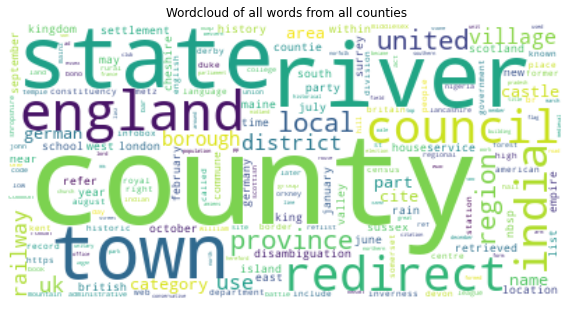

In [23]:
plt.figure(figsize=(10,20))
county_wordcloud = WordCloud(collocations=False,  background_color='white').generate(county_WordCloudText)
plt.imshow(county_wordcloud, interpolation='bilinear')
plt.title('Wordcloud of all words from all counties')
plt.axis("off")